# Stockformer Demo

In [1]:
import sys
# if not 'Informer2020' in sys.path:
#     sys.path += ['Informer2020']

## Experiments: Train and Test

In [2]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils.ipynb_helpers import args_from_setting, setting_from_args, handle_gpu, read_data

In [11]:
args = dotdict()
args.des = 'full_1h'

args.model = 'stockformer' # 'stockformer' 'mlp'

args.data = 'custom' # data
args.checkpoints = './checkpoints' # location of model checkpoints
args.root_path = './data/ETT/' # root path of data file

args.data_path = 'full_1h.csv' # data file
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h

args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'XOM_pctchange' # target feature in S or MS task


args.seq_len = 16 # input sequence length of Informer encoder
args.label_len = 4 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length

#["XOM_close", "BP_close", "CVX_close", "WTI_close"]
#["XOM_open", "XOM_high", "XOM_low", "XOM_close", "XOM_volume", "XOM_pctchange", "XOM_shortsma"]
args.cols = ["XOM_open", "XOM_close", "XOM_pctchange", "XOM_shortsma", 
                'CVX_pctchange', 'COP_pctchange', 'BP_pctchange', 'PBR_pctchange', 
                'WTI_pctchange', 'EOG_pctchange', 'ENB_pctchange', 'SLB_pctchange',
                ]#'C:USDSAR_pctchange'

args.enc_in = len(args.cols) # encoder input size
args.dec_in = len(args.cols) # decoder input size # TODO: Remove
args.c_out = 1 if args.features in ["S", "MS"] else args.dec_in # output size


args.d_model = 512 # dimension of model; this is also the dimension of the token embeddings !!!!!!
args.n_heads = 8 # num of attention heads
args.e_layers = 12 # num of encoder layers
args.d_layers = 4 # num of decoder layers # TODO: Remove
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.embed = None #'timeF' # time features encoding, options:[timeF, fixed, learned, None]
args.activation = 'gelu' # activation

args.attn = 'full' # attention used in encoder, options:[prob, full]
args.factor = 5 # probsparse attn factor; doesn't matter unless args.attn==full
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in encoder
args.mix = False # whether to use mixed attention
args.padding = 0 # TODO: Remove

args.batch_size = 128 #64
args.learning_rate = 0.00001
args.loss = 'mse'
args.lradj = "None" # What learning rate scheduler to use: ["type3", None, "type1"]
args.train_epochs = 50
args.patience = 10 # For early stopping

args.use_amp = False # whether to use automatic mixed precision training
args.num_workers = 0
args.itr = 1 # number of runs

args.scale = True # whether to scale to mean 0, var 1
args.inverse = False # whether to invert that scale before loss is calculated, lets keep this at False

# This is for debugging to overfit
# When True, patience doesn't matter at all and the model-state that is saved is the one after the last epoch
# When False, the model-state that is saved is the one with the highest validation-loss and we can early stop with patience
args.no_early_stop = True 


# Control data split from args, either a date string like "2000-01-30" or None (for default)
args.date_start = "2012-01-01" # Train data starts on this date, default is to go back as far as possible
args.date_end = "2020-01-01" # Train data starts on this date, default is to go back as far as possible
args.date_test = "2019-06-01" # Test data is data after this date, default is to use ~20% of the data as test data



#args.load_model_path = "stockformer_custom_ftMS_sl16_ll4_pl1_ei12_di12_co1_iFalse_dm512_nh8_el12_dl4_df2048_atfull_fc5_ebtimeF_dtFalse_mxFalse_pretrain_full_1h_0/checkpoint-pretrain.pth"

# Code to handle gpu
# None to use all available GPUs
# False for not using GPUs, 
# 0 for using cuda:0, 
# "0,1" for using both cuda:0 and cuda:1
handle_gpu(args, '0,1,2,3')

# TODO: Figure out what this is for
args.detail_freq = args.freq
args.freq = args.freq[-1:]


print('Args in experiment:')
print(args)
Exp = Exp_Informer


# import json
# with open("configs/no_hist.json", "w") as f:
#     json.dump(args, f, indent=4)


Args in experiment:
{'des': 'full_1h', 'model': 'stockformer', 'data': 'custom', 'checkpoints': './checkpoints', 'root_path': './data/ETT/', 'data_path': 'full_1h.csv', 'freq': 'h', 'features': 'MS', 'target': 'XOM_pctchange', 'seq_len': 16, 'label_len': 4, 'pred_len': 1, 'cols': ['XOM_open', 'XOM_close', 'XOM_pctchange', 'XOM_shortsma', 'CVX_pctchange', 'COP_pctchange', 'BP_pctchange', 'PBR_pctchange', 'WTI_pctchange', 'EOG_pctchange', 'ENB_pctchange', 'SLB_pctchange'], 'enc_in': 12, 'dec_in': 12, 'c_out': 1, 'd_model': 512, 'n_heads': 12, 'e_layers': 12, 'd_layers': 4, 'd_ff': 2048, 'dropout': 0.05, 'embed': None, 'activation': 'gelu', 'attn': 'full', 'factor': 5, 'distil': False, 'output_attention': False, 'mix': False, 'padding': 0, 'batch_size': 128, 'learning_rate': 1e-05, 'loss': 'mse', 'lradj': 'type3', 'train_epochs': 50, 'patience': 10, 'use_amp': False, 'num_workers': 0, 'itr': 1, 'scale': True, 'inverse': False, 'no_early_stop': False, 'date_start': '2012-01-01', 'date_end'

### Train & Test *args.itr* models

In [7]:
exp = None
setting = None
for ii in range(args.itr):
    # setting record of experiments
    setting = setting_from_args(args, ii)
    
    # set experiments
    exp = Exp(args)
    
    # train
    print(f">>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>")
    exp.train(setting)
    
    # test
    print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    exp.test(setting, flag="test", inverse=True)
    exp.test(setting, flag="val", inverse=True)
    exp.test(setting, flag="train", inverse=True)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : stockformer_custom_ftMS_sl16_ll4_pl1_ei12_di12_co1_iFalse_dm512_nh8_el12_dl4_df2048_atfull_fc5_ebNone_dtFalse_mxFalse_full_1h_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7478
val 1072
test 2141
Epoch: 1 cost time: 6.067507266998291
Epoch: 1, Steps: 58 | Train Loss: 1.3714450 Vali Loss: 1.3939278 Test Loss: 1.4707810
Epoch: 2 cost time: 5.802899122238159
Epoch: 2, Steps: 58 | Train Loss: 1.2622560 Vali Loss: 1.2675917 Test Loss: 1.3660476
Epoch: 3 cost time: 5.73417592048645
Epoch: 3, Steps: 58 | Train Loss: 1.0090491 Vali Loss: 1.2871425 Test Loss: 1.3791397
Epoch: 4 cost time: 5.7334840297698975
Epoch: 4, Steps: 58 | Train Loss: 1.0019560 Vali Loss: 1.2067646 Test Loss: 1.3248444
Epoch: 5 cost time: 5.748569488525391
Epoch: 5, Steps: 58 | Train Loss: 0.9924842 Vali Loss: 1.2908038 Test Loss: 1.3859255
Epoch: 6 cost time: 5.751834392547607
Epoch: 6, Steps: 58 | Train Loss: 0.9798096 Vali Loss: 1.2195448 Test Loss: 1.3378972
Epoch: 7 cost time: 5.7594678401

In [113]:
# exp.test(setting, flag="test", inverse=False)
# exp.test(setting, flag="val", inverse=False)
# exp.test(setting, flag="train", inverse=False)

## Prediction

In [8]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

manual = False

if manual:
    setting = "informer_custom_ftMS_sl256_ll64_pl16_ei1_di1_co1_iFalse_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0"
    args = args_from_setting(setting, args)
    exp = Exp(args)

path = os.path.join(args.checkpoints, setting, "checkpoint.pth")

exp.predict(setting, True)

# the prediction will be saved in ./results/{setting}/real_prediction.npy
prediction = np.load(f"./results/{setting}/real_prediction.npy")

print(prediction.shape)

# plt.figure()
# plt.plot(prediction[0,:,-1])
# plt.show()

pred 1
(1, 1, 1)


## Visualization

In [9]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

tp_dict = {}
for flag in ["train", "val", "test"]:
    preds_path = f"./results/{setting}/pred_{flag}.npy"
    trues_path = f"./results/{setting}/true_{flag}.npy"
    dates_path = f"./results/{setting}/date_{flag}.npy"
    if os.path.exists(preds_path) and os.path.exists(trues_path) and os.path.exists(dates_path):
        tp_dict[flag] = (np.load(trues_path), np.load(preds_path), np.load(dates_path))
        # tp_dict[flag] = list(zip(*sorted(zip(*tp_dict[flag]), key=lambda x: x[-1])))
        s = np.argsort(tp_dict[flag][2], axis=None)
        tp_dict[flag] = list(map(lambda x: x[s], tp_dict[flag]))
        

print("Open true/pred data for:", list(tp_dict.keys()))

# [samples, pred_len, dimensions]
print(tp_dict["train"][0].shape, tp_dict["val"][0].shape, tp_dict["test"][0].shape, "\n\n")

for flag in tp_dict:
    trues, preds, dates = tp_dict[flag]
    print(f"{flag}\ttrues.shape: {trues.shape}, preds.shape: {preds.shape}, dates.shape: {preds.shape}")
    
    MSE = np.square(np.subtract(trues,preds)).mean() 
    RMSE = np.sqrt(MSE)
    print("against preds", MSE, RMSE)

    MSE = np.square(np.subtract(trues,np.zeros(preds.shape))).mean() 
    RMSE = np.sqrt(MSE)
    print("against 0s", MSE, RMSE)

Open true/pred data for: ['train', 'val', 'test']
(7424, 1, 1) (1024, 1, 1) (2048, 1, 1) 


train	trues.shape: (7424, 1, 1), preds.shape: (7424, 1, 1), dates.shape: (7424, 1, 1)
against preds 1.2334226e-06 0.0011105957
against 0s 9.826735263254693e-06 0.003134762393428678
val	trues.shape: (1024, 1, 1), preds.shape: (1024, 1, 1), dates.shape: (1024, 1, 1)
against preds 1.6082908e-05 0.00401035
against 0s 1.1995594626081006e-05 0.003463465695814094
test	trues.shape: (2048, 1, 1), preds.shape: (2048, 1, 1), dates.shape: (2048, 1, 1)
against preds 1.7112488e-05 0.0041367244
against 0s 1.2836622488723325e-05 0.003582823256696222


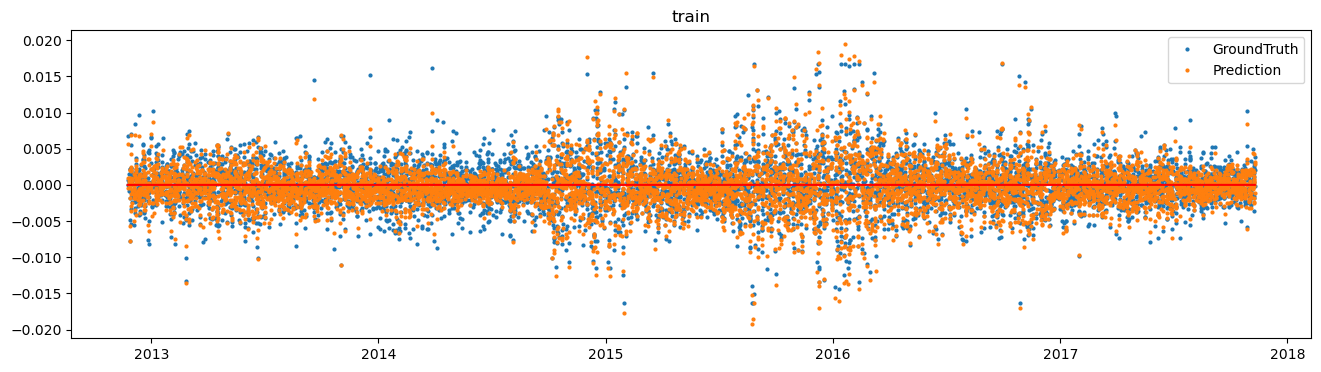

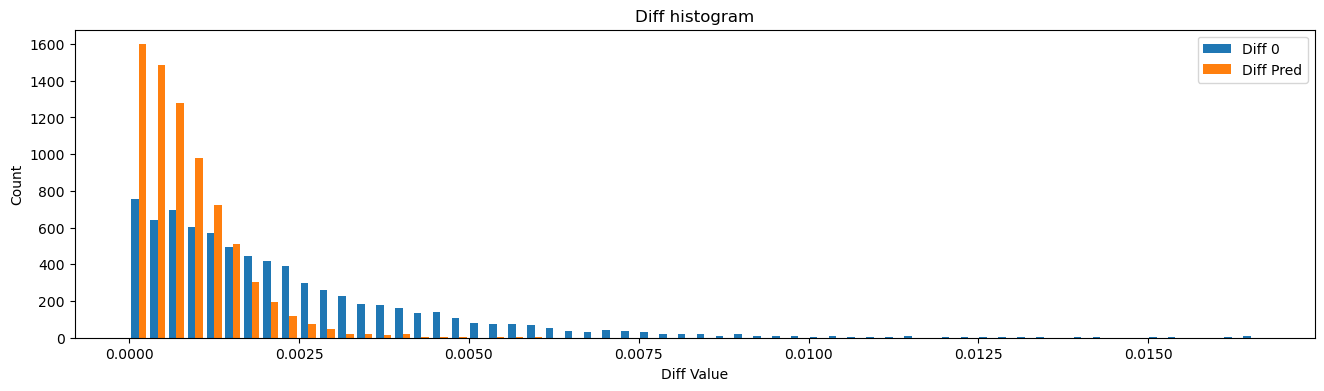

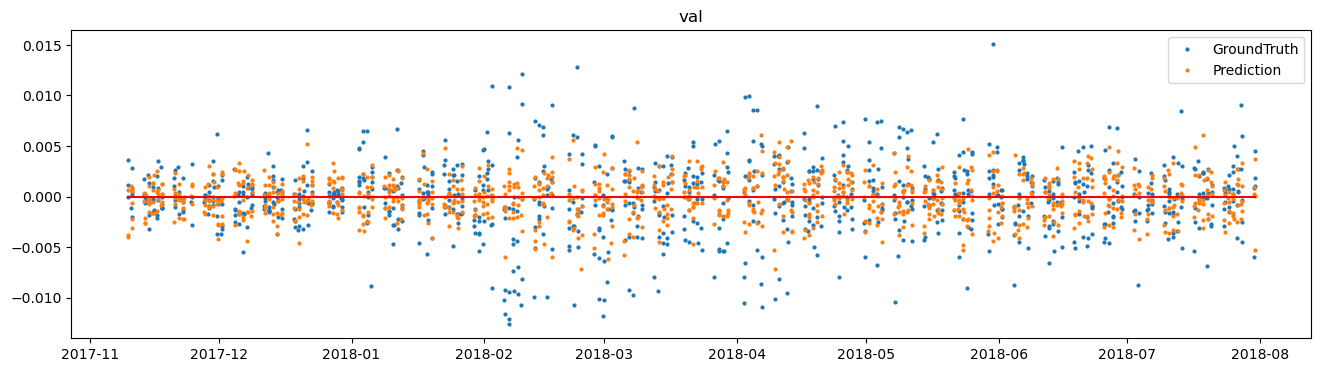

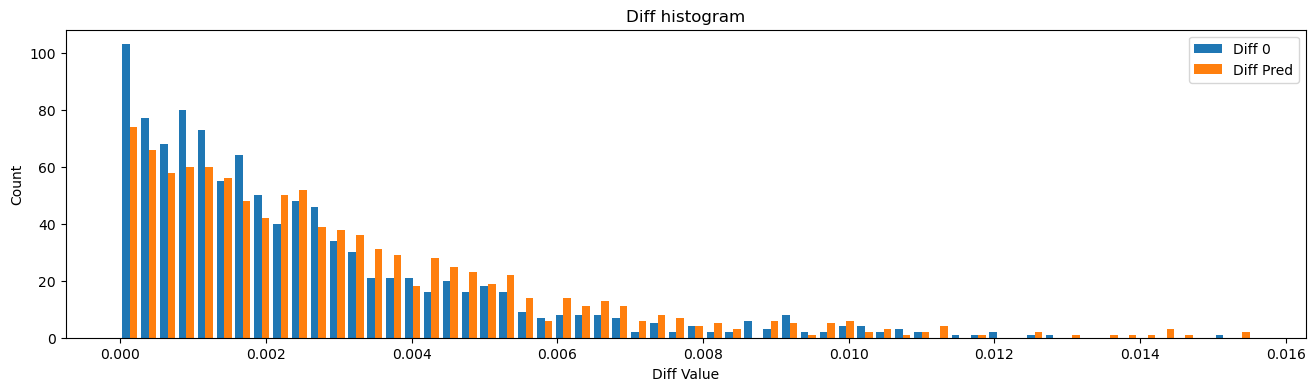

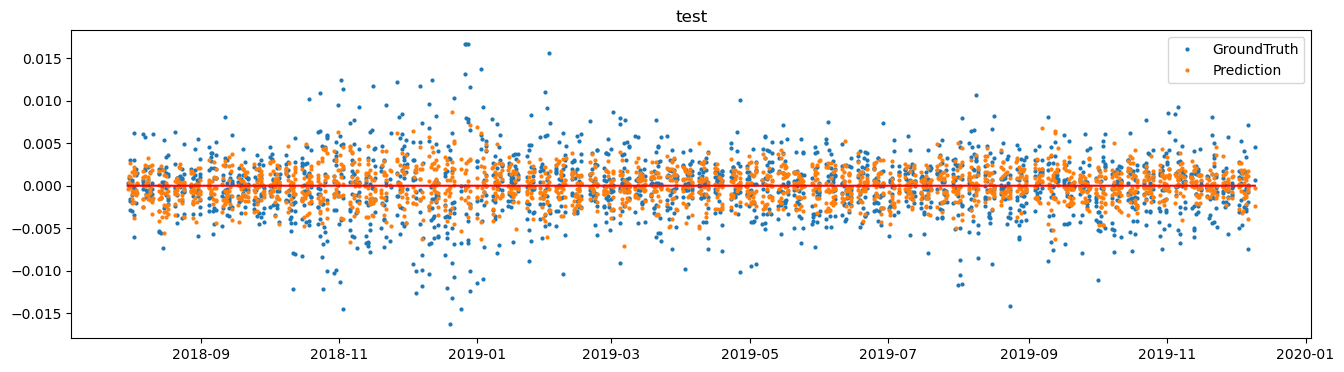

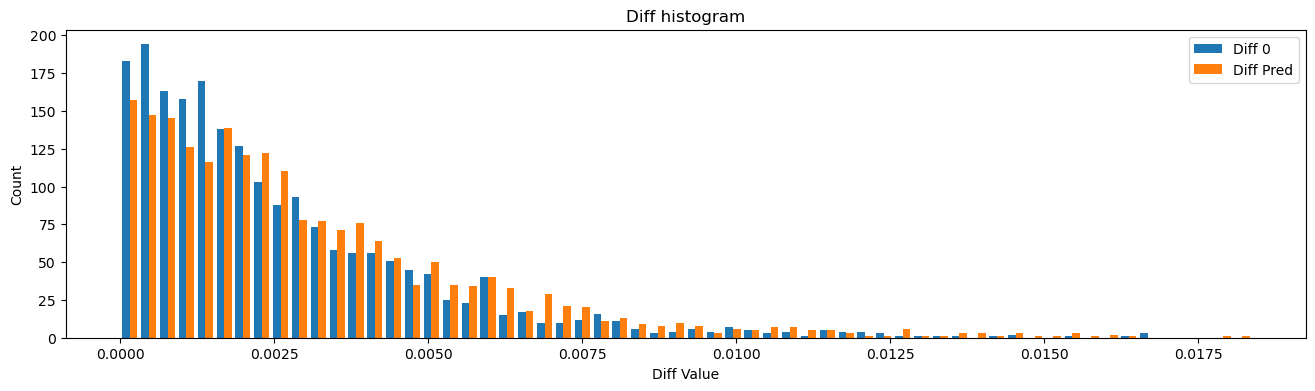

In [10]:
# draw OT prediction
for flag in tp_dict:
    trues, preds, dates = tp_dict[flag]
    true = trues[:,0,0]
    pred = preds[:,0,0]
    date = dates[:,0]
    plt.figure(num=flag, figsize=(16,4))
    plt.title(flag)
    plt.plot(date, true, label='GroundTruth', linestyle="",marker=".",markersize=4)
    plt.plot(date, pred, label='Prediction',linestyle="",marker=".",markersize=4)
    plt.plot(date, np.zeros(date.shape), color="red")
    # plt.scatter(range(trues.shape[0]), trues[:,0,0], marker='v', color='r', label='GroundTruth')
    # plt.scatter(range(trues.shape[0]), preds[:,0,0], marker='^', color='m', label='Prediction')

    plt.legend()
    plt.show()

    plt.figure(num=flag, figsize=(16,4))
    plt.title("Diff histogram")
    # plt.hist(np.abs(true), bins=len(true)//6, label='Diff 0', alpha=0.5)
    # plt.hist(np.abs(true - pred), bins=len(true)//6, label='Diff Pred', alpha=0.5)
    plt.hist([np.abs(true), np.abs(true - pred)], bins=60, label=['Diff 0', 'Diff Pred'])
    plt.xlabel("Diff Value")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    # df = pd.concat([pd.DataFrame(a, columns=[f"{i}"]) for i, a in enumerate([np.abs(true - pred), np.abs(true)])], axis=1)

    # # plot the data
    # df.plot.hist(stacked=True, bins=len(true), density=True, figsize=(10, 6), grid=True)
    

In [117]:
max_tracker = (0, 0)
m = 0
v = 0

# train percent direction correct, train num excluded,
# val percent direction correct, val num excluded,
# test percent direction correct, test num excluded
tracker = {} 

for thresh in np.linspace(0, .00025, 501):
    # print("thresh:", thresh)
    track = {}
    for flag in tp_dict:
        trues, preds, dates = tp_dict[flag]
        true = trues[:,0,0].copy()
        pred = preds[:,0,0].copy()
        
        pred_c = pred[np.abs(pred) >= thresh]
        true_c = true[np.abs(pred) >= thresh]
        # print(flag, "num excluded:", len(pred) - len(pred_c), len(pred_c))
        pct_dir_correct = np.sum(np.sign(true_c) == np.sign(pred_c))/len(true_c)
        # print(flag, pct_dir_correct)
        if pct_dir_correct > max_tracker[0] and flag=='val':
            max_tracker = (pct_dir_correct, thresh)
        
        track[f"{flag}_pct_dir_correct"] = pct_dir_correct
        track[f"{flag}_pct_excluded"] = (len(pred) - len(pred_c))/len(pred)

    tracker[thresh] = track

best_thresh = max_tracker[1]
print("best thresh", best_thresh)
print(tracker[best_thresh])



best thresh 0.00012299999999999998
{'train_pct_dir_correct': 0.48660518225735616, 'train_pct_excluded': 0.07987607758620689, 'val_pct_dir_correct': 0.4940152339499456, 'val_pct_excluded': 0.1025390625, 'test_pct_dir_correct': 0.4956663055254605, 'test_pct_excluded': 0.0986328125}


In [118]:
max_tracker = (0, 0)

# train percent direction correct, train num excluded,
# val percent direction correct, val num excluded,
# test percent direction correct, test num excluded
tracker = {}

# df = pd.read_csv(os.path.join(args.root_path, args.data_path), index_col = "date")
df = read_data(os.path.join(args.root_path, args.data_path))


for thresh in np.linspace(0, .00025, 501):
    # print("thresh:", thresh)
    tracker[thresh] = {}
    track = {}
    for flag in tp_dict:
        trues, preds, dates = tp_dict[flag]
        # trues, preds = np.exp(trues), np.exp(preds)
        true = trues[:,0,0].copy()
        pred = preds[:,0,0].copy()
        date = pd.DatetimeIndex(dates[:,0], tz="UTC")

        df_flag = df.loc[date][np.abs(pred) >= thresh]
        true_c = true[np.abs(pred) >= thresh]
        pred_c = pred[np.abs(pred) >= thresh]

        # turn pct_change to price change

        ticker, field = args.target.split("_")
        assert field == "pctchange"
        true_c, pred_c = np.exp(true_c), np.exp(pred_c)
        true_price_change = df_flag[ticker]["open"] * (true_c-1)
        pred_price_change = df_flag[ticker]["open"] * (pred_c-1)


        # pred = pred[np.abs(pred) >= thresh]
        # true = true[np.abs(pred) >= thresh]

        pred_price_change = pred_price_change[np.abs(pred_c) >= thresh]
        true_price_change = true_price_change[np.abs(pred_c) >= thresh]

        # profit if you always bought one share with shorting
        p_one_share_wshort = (true_price_change * np.sign(pred_price_change)).sum()

        # percent profit with shorting
        pct_profit_wshort = ((true_c-1) * np.sign(pred_c-1) + 1).prod()

        # profit if you always bought one share without shorting
        p_one_share = (true_price_change * np.sign(pred_price_change))[pred_price_change > 0].sum()

        # percent profit without shorting
        pct_profit = ((true_c-1) * np.sign(pred_c-1) + 1)[pred_c > 1].prod()

        pct_profit_opt = ((true_c-1) * np.sign(true_c-1) + 1)[true_c > 1].prod()

        # tune threshhold based off of val pct_profit
        if pct_profit > max_tracker[0] and flag=='val':
            max_tracker = (pct_profit, thresh)


        tracker[thresh][flag] = {"pct_profit": pct_profit, "pct_profit_wshort": pct_profit_wshort, 
                            "p_one_share": p_one_share, "p_one_share_wshort": p_one_share_wshort, 
                            "pct_excluded":(len(pred) - len(pred_c))/len(pred),
                            "pct_profit_opt": pct_profit_opt}


best_thresh = max_tracker[1]
print("best thresh", best_thresh)
for k in tracker[best_thresh]:
    print(f"{k}\t", tracker[best_thresh][k])

best thresh 0.00013099999999999999
train	 {'pct_profit': 0.9907582, 'pct_profit_wshort': 0.9907582, 'p_one_share': -0.7414040031433107, 'p_one_share_wshort': -0.7414040031433107, 'pct_excluded': 0.9991918103448276, 'pct_profit_opt': 1.0032265}
val	 {'pct_profit': 1.0003921, 'pct_profit_wshort': 1.0003921, 'p_one_share': 0.029991872310638407, 'p_one_share_wshort': 0.029991872310638407, 'pct_excluded': 0.9970703125, 'pct_profit_opt': 1.0017987}
test	 {'pct_profit': 1.0002939, 'pct_profit_wshort': 1.0002939, 'p_one_share': 0.05999714672565462, 'p_one_share_wshort': 0.05999714672565462, 'pct_excluded': 0.998046875, 'pct_profit_opt': 1.0041019}


## Attention Visualization

In [119]:
args.output_attention = True

exp = Exp(args)

model = exp.model

path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

print(model.load_state_dict(torch.load(path)))

df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df[args.cols].head()

Use GPU: cuda:0
<All keys matched successfully>


,XOM_open,XOM_close,XOM_pctchange,XOM_shortsma,CVX_pctchange,COP_pctchange,BP_pctchange,PBR_pctchange,WTI_pctchange,EOG_pctchange,ENB_pctchange,SLB_pctchange
0,87.34,87.1400,-0.002293,87.14000,-0.003593,-0.001395,-0.001291,-0.010537,-0.008485,-0.002286,0.002070,0.003870
1,87.16,87.4701,0.003552,87.47010,0.000722,0.003234,0.002677,0.004753,0.009094,0.006674,0.001808,0.008405
2,87.47,87.6500,0.002056,87.65000,0.003456,-0.000538,0.002428,0.006303,0.009615,-0.001096,0.000774,0.002833
3,87.53,87.4600,-0.000800,87.57136,0.000357,0.000180,-0.002176,0.002623,-0.007194,-0.006371,0.001552,-0.003704
4,87.47,87.6600,0.002170,87.60934,0.001734,0.002451,-0.000485,0.001570,-0.007862,-0.004611,-0.000259,-0.000642


In [120]:
from data_provider.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1
data_set = Data(args, flag=flag, freq=args.freq, timeenc=timeenc)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)



print(attn[0].shape, attn[1].shape) #, attn[2].shape



layers = [0,1]
distil = 'Distil' if args.distil else 'NoDistil'
for layer in layers:
    print("\n\n==========================")
    print("Showing attention layer", layer)
    print("==========================\n\n")
    for h in range(0, args.n_heads):
        plt.figure(figsize=[10,8])
        plt.title(f"Informer, {distil}, attn:{args.attn} layer:{layer} head:{h}")
        A = attn[layer][0,h].detach().cpu().numpy()
        ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
        plt.show()

ValueError: too many values to unpack (expected 4)